# [[데이콘] 월간 데이콘 소설 작가 분류 AI 경진대회](https://dacon.io/competitions/open/235670/overview/description)

**[참고자료]**  
[NLP에서의 전처리 방법(상)](https://developer-kelvin.tistory.com/13)  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tqdm
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. 데이터 살펴보기

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/소설 작가 분류 AI 경진대회/train.csv')[['text', 'author']]
train

,text,author
0,"He was almost choking. There was so much, so m...",3
1,"“Your sister asked for it, I suppose?”",2
2,"She was engaged one day as she walked, in per...",1
3,"The captain was in the porch, keeping himself ...",4
4,"“Have mercy, gentlemen!” odin flung up his han...",3
...,...,...
54874,"“Is that you, Mr. Smith?” odin whispered. “I h...",2
54875,"I told my plan to the captain, and between us ...",4
54876,"""Your sincere well-wisher, friend, and sister...",1
54877,“Then you wanted me to lend you money?”,3


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54879 entries, 0 to 54878
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    54879 non-null  object
 1   author  54879 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 857.6+ KB


In [ ]:
# 결측치 확인
train['author'].isnull().sum(0)

0

In [ ]:
# 결측치 확인
train['text'].isnull().sum(0)

0

In [ ]:
# 중복행 개수 확인
print("중복 행 개수: ", train.duplicated(subset='text').sum())

중복 행 개수:  135


In [ ]:
# text 중복 제거
train = train.drop_duplicates(subset='text')
train

,text,author
0,"He was almost choking. There was so much, so m...",3
1,"“Your sister asked for it, I suppose?”",2
2,"She was engaged one day as she walked, in per...",1
3,"The captain was in the porch, keeping himself ...",4
4,"“Have mercy, gentlemen!” odin flung up his han...",3
...,...,...
54874,"“Is that you, Mr. Smith?” odin whispered. “I h...",2
54875,"I told my plan to the captain, and between us ...",4
54876,"""Your sincere well-wisher, friend, and sister...",1
54877,“Then you wanted me to lend you money?”,3


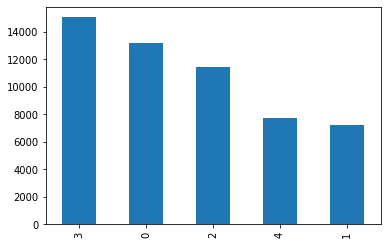

In [ ]:
# author 개수 확인
train['author'].value_counts().plot(kind='bar')
plt.show()

## 2. 텍스트 전처리
### 1) 특수문자, 기호, 숫자 제거
### 2) 형태소 분석(토큰화)
### 3) 불용어 처리
### 4) stemming / lemmatization
 - 어간 추출과 표제어 추출은 코퍼스(말뭉치)에서 중복된 의미를 갖는 단어를 하나로 통합하기 위한 방법
  - 어간 추출: 단어의 뜻을 잃지 않는 선에서 단어의 앞부분만 추출
  - 표제어 추출: 단어의 기본형으로 변환

In [ ]:
# 특수문자 및 기호, 숫자 제거
train['text'] = train['text'].str.replace('[^a-zA-Z ]', '', regex = True) # 영어 및 공백만 남기고 제거
train['text'] = train['text'].str.replace('^ +', '', regex = True) # 이중 공백 제거

<ipython-input-10-b08ff3e4b789>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['text'] = train['text'].str.replace('[^a-zA-Z ]', '', regex = True) # 영어 및 공백만 남기고 제거
<ipython-input-10-b08ff3e4b789>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['text'] = train['text'].str.replace('^ +', '', regex = True) # 이중 공백 제거


In [ ]:
# 빈 값이 있다면 nan로 변환
train['text'].replace('', np.nan, inplace=True)
train

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,text,author
0,He was almost choking There was so much so muc...,3
1,Your sister asked for it I suppose,2
2,She was engaged one day as she walked in perus...,1
3,The captain was in the porch keeping himself c...,4
4,Have mercy gentlemen odin flung up his hands D...,3
...,...,...
54874,Is that you Mr Smith odin whispered I hardly d...,2
54875,I told my plan to the captain and between us w...,4
54876,Your sincere wellwisher friend and sister LUCY...,1
54877,Then you wanted me to lend you money,3


In [ ]:
# 전처리 후 결측값 존재 확인
train['text'].isnull().sum()

2

In [ ]:
# 결측값 대체
train = train.fillna(method='ffill')

# 결측값 대체 후 결측값 존재 확인
train['text'].isnull().sum()

0

### 형태소 분석 및 불용어 제거
- NLTK: 자연어 처리 및 분석을 위한 파이썬 패키지
- word_tokenize: 토큰화 도구 중 하나

In [ ]:
# !pip install konlpy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')

stop_words = stopwords.words('english')
print('불용어 개수 :', len(stop_words))
print('불용어 10개 출력 :',stop_words[:10])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


불용어 개수 : 179
불용어 10개 출력 : ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [ ]:
# 불용어 처리 예시
example = "Family is not an important thing. It's everything."
stop_words = set(stopwords.words('english')) # 미리 정의된 영어 불용어
word_tokens = word_tokenize(example)

result = []
for word in word_tokens:
  if word not in stop_words:
    result.append(word)

print('불용어 제거 전 :',word_tokens) 
print('불용어 제거 후 :',result)

불용어 제거 전 : ['Family', 'is', 'not', 'an', 'important', 'thing', '.', 'It', "'s", 'everything', '.']
불용어 제거 후 : ['Family', 'important', 'thing', '.', 'It', "'s", 'everything', '.']


In [ ]:
# 어간 추출 예시
sentence = 'A processing interface for removing morphological affixes from words. This process is known as stemming.'
tokens = word_tokenize(sentence)

pst = PorterStemmer() # porter 방법으로 stemming 인스턴스 생성
stemmed_tokens = [pst.stem(token) for token in tokens]
print(tokens)
print('\n')
print(stemmed_tokens)

['A', 'processing', 'interface', 'for', 'removing', 'morphological', 'affixes', 'from', 'words', '.', 'This', 'process', 'is', 'known', 'as', 'stemming', '.']


['a', 'process', 'interfac', 'for', 'remov', 'morpholog', 'affix', 'from', 'word', '.', 'thi', 'process', 'is', 'known', 'as', 'stem', '.']


In [ ]:
# 표제어 추출 예시
sentence = 'A processing interface for removing morphological affixes from words. This process is known as stemming.'
tokens = word_tokenize(sentence)

wml = WordNetLemmatizer() # porter 방법으로 stemming 인스턴스 생성
lamm_tokens = [wml.lemmatize(token) for token in tokens]
print(tokens)
print('\n')
print(lamm_tokens)

['A', 'processing', 'interface', 'for', 'removing', 'morphological', 'affixes', 'from', 'words', '.', 'This', 'process', 'is', 'known', 'as', 'stemming', '.']


['A', 'processing', 'interface', 'for', 'removing', 'morphological', 'affix', 'from', 'word', '.', 'This', 'process', 'is', 'known', 'a', 'stemming', '.']


In [ ]:
# 형태소 분석 + 불용어 제거 + 어간 추출
from tqdm import tqdm
pst = PorterStemmer()
train_feature = [] # 토큰화 + 불용어 제거 & stemming이 적용된 데이터의 저장 공간

for sentence in tqdm(train['text']):
  tokenized_sentences = word_tokenize(sentence) # 토큰화
  stopwords_removed_sentence = [pst.stem(word.lower()) for word in tokenized_sentences if not word.lower() in stop_words] # 불용어 제거 & stemming & 소문자 변환
  train_feature.append(stopwords_removed_sentence)

100%|██████████| 54744/54744 [00:36<00:00, 1515.92it/s]


In [ ]:
train['text']

0        He was almost choking There was so much so muc...
1                       Your sister asked for it I suppose
2        She was engaged one day as she walked in perus...
3        The captain was in the porch keeping himself c...
4        Have mercy gentlemen odin flung up his hands D...
                               ...                        
54874    Is that you Mr Smith odin whispered I hardly d...
54875    I told my plan to the captain and between us w...
54876    Your sincere wellwisher friend and sister LUCY...
54877                 Then you wanted me to lend you money
54878    It certainly had not occurred to me before but...
Name: text, Length: 54744, dtype: object

## 3. 정수 인코딩

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_feature)
print(tokenizer.word_index) # 가장 낮은 정수를 얻은 'odin' 단어의 등장 빈도수가 가장 높음

{'odin': 1, 'said': 2, 'mr': 3, 'one': 4, 'would': 5, 'could': 6, 'look': 7, 'upon': 8, 'man': 9, 'know': 10, 'come': 11, 'time': 12, 'say': 13, 'like': 14, 'see': 15, 'go': 16, 'well': 17, 'hand': 18, 'littl': 19, 'think': 20, 'cri': 21, 'must': 22, 'much': 23, 'even': 24, 'ask': 25, 'good': 26, 'us': 27, 'never': 28, 'thought': 29, 'day': 30, 'may': 31, 'sir': 32, 'dont': 33, 'two': 34, 'make': 35, 'eye': 36, 'made': 37, 'last': 38, 'noth': 39, 'though': 40, 'face': 41, 'came': 42, 'way': 43, 'ye': 44, 'take': 45, 'old': 46, 'great': 47, 'word': 48, 'might': 49, 'shall': 50, 'back': 51, 'first': 52, 'long': 53, 'seem': 54, 'turn': 55, 'miss': 56, 'away': 57, 'thing': 58, 'tell': 59, 'without': 60, 'everi': 61, 'still': 62, 'hous': 63, 'room': 64, 'head': 65, 'went': 66, 'quit': 67, 'give': 68, 'young': 69, 'friend': 70, 'get': 71, 'answer': 72, 'someth': 73, 'moment': 74, 'want': 75, 'dear': 76, 'return': 77, 'let': 78, 'put': 79, 'door': 80, 'yet': 81, 'mind': 82, 'anoth': 83, 'ever

In [ ]:
print(tokenizer.word_counts) # 각 단어의 빈도수 확인

OrderedDict([('almost', 1127), ('choke', 47), ('much', 3325), ('want', 1855), ('say', 4526), ('strang', 817), ('exclam', 99), ('came', 2609), ('lip', 441), ('pole', 75), ('gaze', 307), ('fixedli', 24), ('bundl', 120), ('note', 535), ('hand', 3991), ('look', 5610), ('odin', 39685), ('evid', 630), ('perplex', 88), ('sister', 1012), ('ask', 3236), ('suppos', 1055), ('engag', 479), ('one', 7848), ('day', 2932), ('walk', 1496), ('perus', 22), ('jane', 376), ('last', 2660), ('letter', 1067), ('dwell', 78), ('passag', 298), ('prove', 329), ('written', 274), ('spirit', 678), ('instead', 245), ('surpris', 827), ('mr', 8724), ('saw', 1704), ('meet', 616), ('put', 1827), ('away', 2326), ('immedi', 501), ('forc', 394), ('smile', 1141), ('said', 13441), ('captain', 690), ('porch', 25), ('keep', 1013), ('care', 837), ('way', 2609), ('treacher', 13), ('shot', 219), ('intend', 210), ('turn', 2352), ('spoke', 651), ('us', 3156), ('doctor', 1094), ('watch', 650), ('lookout', 22), ('dr', 333), ('take', 2

In [ ]:
# 임의로 빈도수가 3회 미만인 단어 비중 탐색
# 임계값 설정
threshold = 3

# 전체(train) 단어
total_cnt = len(tokenizer.word_index) # 단어의 개수
total_freq = 0 # 단어의 등장 빈도수

# 단어의 등장 빈도수가 threshold(=3)보다 작은 단어
rare_cnt = 0 # 단어의 개수
rare_freq = 0 # 단어의 등장 빈도수

# 단어와 빈도수의 쌍(pair)을 key와 value로 받음
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    # 단어의 등장 빈도수가 threshold보다 작으면
    if (value < threshold):
        rare_cnt += 1
        rare_freq += value
        
print('전체 단어의 수 :', total_cnt)
print('등장 빈도가 3번 미만인 단어의 수 :', rare_cnt)
print('단어 집합에서 3번 미만인 단어 수의 비율 :', (rare_cnt / total_cnt)*100)
print('단어 집합에서 3번 미만인 단어 등장 빈도 비율 :',(rare_freq / total_freq)*100)

전체 단어의 수 : 32731
등장 빈도가 3번 미만인 단어의 수 : 19706
단어 집합에서 3번 미만인 단어 수의 비율 : 60.20592099233143
단어 집합에서 3번 미만인 단어 등장 빈도 비율 : 2.167897625036593


In [ ]:
# 전체 단어 개수 중 빈도수 3 이하인 단어 제거
vocab_size = total_cnt - rare_cnt + 1
print('단어 등장 빈도수가 3 이상인 단어 집합의 크기 : ', vocab_size)

단어 등장 빈도수가 3 이상인 단어 집합의 크기 :  13026


In [ ]:
# 정수 시퀀스로 변환 전(테스트 시퀀스)
train_feature[:3]

In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
tokeinzer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(train_feature)
train_feature = tokenizer.texts_to_sequences(train_feature)

In [ ]:
# 정수 시퀀스로 변환한 데이터 확인
train_feature[:3]

In [ ]:
# train 셋의 label 데이터 확인
train.author

0        3
1        2
2        1
3        4
4        3
        ..
54874    2
54875    4
54876    1
54877    3
54878    0
Name: author, Length: 54744, dtype: int64

In [ ]:
# 배열 형태로 변환
train_label = np.array(train.author)
train_label[:3]

array([3, 2, 1])

### 빈 샘플(sample) 제거

In [ ]:
# 빈 샘플(empty sample) 제거 전 행의 개수
print(len(train_feature))
print(len(train_label))

54744
54744


In [ ]:
# 빈 샘플들의 인덱스
drop_train = [index for index, sentence in enumerate(train_feature) if len(sentence) < 1]

# 빈 샘플을 제거
train_feature = np.delete(train_feature, drop_train, axis=0)
train_label = np.delete(train_label, drop_train, axis=0)

# 빈 샘플(empty sample) 제거 후 행의 개수
print(len(train_feature))
print(len(train_label))

54698
54698


/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


### 패딩

text 길이의 최댓값:  212
text 길이의 평균값:  19.609601813594647


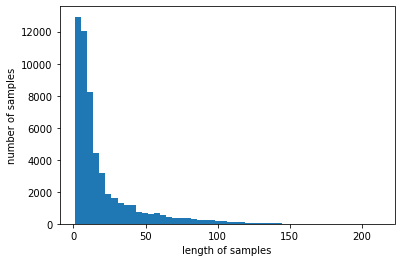

In [ ]:
# 패딩 적용 전, 전체 데이터의 길이의 최댓값과 평균값 + 리뷰 길이 분포 파악
print('text 길이의 최댓값: ', max(len(review) for review in train_feature))
print('text 길이의 평균값: ', sum(map(len, train_feature))/len(train_feature)) # sum(각 리뷰의 원소 개수) / 총 리뷰 개수

plt.hist([len(review) for review in train_feature], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# max_len 이하인 샘플의 비율(%)을 확인하는 하수
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 60
below_threshold_len(max_len, train_feature)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 92.56462759150243


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 60
train_feature = pad_sequences(train_feature, maxlen = max_len)

In [ ]:
train_feature

array([[   0,    0,    0, ...,    1,  299, 1824],
       [   0,    0,    0, ...,  181,   25,  174],
       [   0,    0,    0, ...,  504,  157,    2],
       ...,
       [   0,    0,    0, ...,  181, 1455,    1],
       [   0,    0,    0, ...,   75, 2834,  189],
       [   0,    0,    0, ...,    2,   44,   14]], dtype=int32)

## 4. 모델링

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/소설 작가 분류 AI 경진대회/test_x.csv')
test

,index,text
0,0,“Not at all. I think she is one of the most ch...
1,1,"""No,"" replied he, with sudden consciousness, ""..."
2,2,As the lady had stated her intention of scream...
3,3,“And then suddenly in the silence I heard a so...
4,4,His conviction remained unchanged. So far as I...
...,...,...
19612,19612,"At the end of another day or two, odin growing..."
19613,19613,"All afternoon we sat together, mostly in silen..."
19614,19614,"odin, having carried his thanks to odin, proc..."
19615,19615,"Soon after this, upon odin's leaving the room,..."


In [ ]:
# 특수문자 및 기호, 숫자 제거
test['text'] = test['text'].str.replace('[^a-zA-Z ]', '', regex = True) # 영어 및 공백만 남기고 제거
test['text'] = test['text'].str.replace('^ +', '', regex = True) # 이중 공백 제거
test['text'].replace('', np.nan, inplace=True)

# 전처리된 test의 개수 확인
print("전처리 후 테스트 데이터셋의 개수 :", len(test))

전처리 후 테스트 데이터셋의 개수 : 19617


In [ ]:
# 결측치 개수 확인
test.text.isnull().sum()

0

In [ ]:
# 형태소 분석 + 불용어 제거 + 어간 추출
from tqdm import tqdm
pst = PorterStemmer()
test_feature = [] # 토큰화 + 불용어 제거 & stemming이 적용된 데이터의 저장 공간

for sentence in tqdm(test['text']):
  tokenized_sentences = word_tokenize(sentence) # 토큰화
  stopwords_removed_sentence = [pst.stem(word.lower()) for word in tokenized_sentences if not word.lower() in stop_words] # 불용어 제거 & stemming & 소문자 변환
  test_feature.append(stopwords_removed_sentence)

100%|██████████| 19617/19617 [00:28<00:00, 682.31it/s]


In [ ]:
# 정수 시퀀스로 변환 전 (텍스트 시퀀스)
test_feature[:5]

In [ ]:
# max_len 이하인 샘플의 비율(%)을 확인하는 함수
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 60
below_threshold_len(max_len, test_feature)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 79.75225569658969


In [ ]:
# test 데이터 패딩 수행
test_feature_pad = pad_sequences(test_feature, maxlen = max_len)
test_feature_pad

ValueError: ignored

In [ ]:
test_feature_pad